# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
faces = pd.read_csv('/datasets/faces/labels.csv')

### Загрузка данных

In [3]:
train_datagen = ImageDataGenerator(validation_split=0.25, rescale = 1./255.)
train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=faces,
                                                       directory='/datasets/faces/final_files/',
                                                       x_col='file_name',
                                                       y_col='real_age',
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       class_mode='raw',
                                                       seed=12345)

Found 7591 validated image filenames.


### Размеры датасета

In [4]:
faces.shape

(7591, 2)

In [5]:
faces.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
features, target = next(train_datagen_flow)

In [7]:
print(features.shape)
print(target.shape)

(32, 224, 224, 3)
(32,)


В нашей выборке 7591 фотографий с размерностью 224х224 разделенные на батчи размерами 32.

### График распределения возраста в выборке

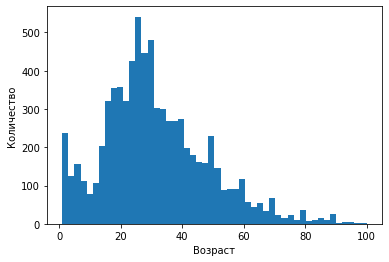

In [8]:
plt.hist(faces.real_age, bins=50)
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()


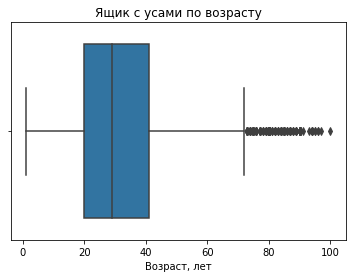

In [9]:
sns.boxplot(faces.real_age)
plt.title('Ящик с усами по возрасту')
plt.xlabel('Возраст, лет')
plt.show()

### Напечатайте на экране 10–15 фотографий и посмотрите, как устроен датасет

In [10]:
faces.head(15)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


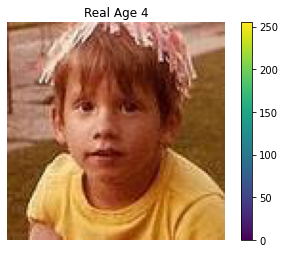

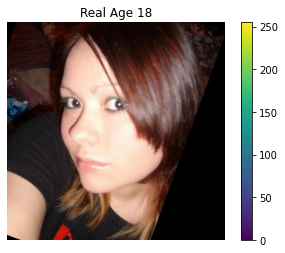

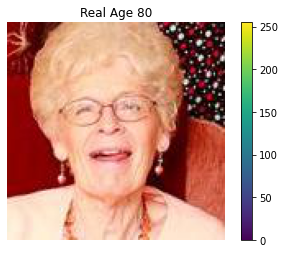

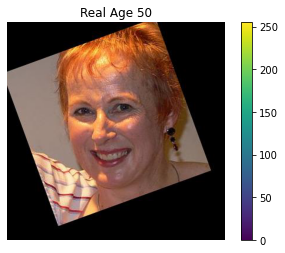

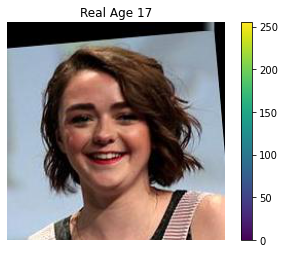

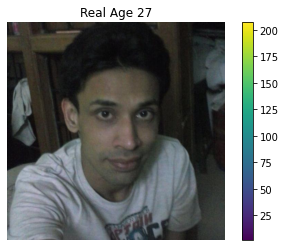

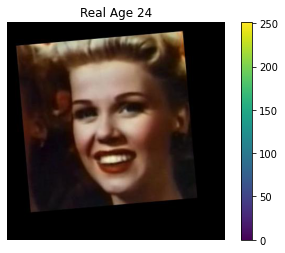

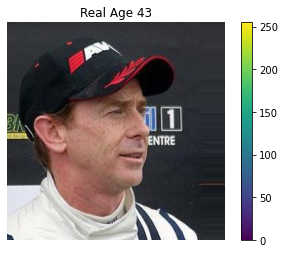

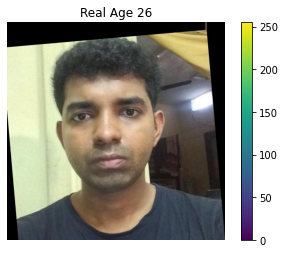

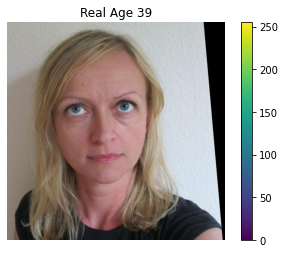

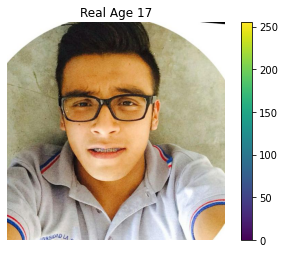

In [19]:
for i,k in zip(faces.file_name[:11],faces.real_age[:11]):
    image = Image.open('/datasets/faces/final_files/'+i)
    array = np.array(image)
    plt.imshow(array)
    plt.title('Real Age {:.0f}'.format(k))
    plt.axis('off')
    plt.colorbar()
    plt.show()

#### Промежуточный вывод

* Нам доступен датасет на 7591 фотографий размером 224х224. 
* Этого количества хватит, чтобы не замораживать первый слой нейронной сети и избежать переобучения.
* Так же в датасете есть фото, со сдвигами по горизонтали.
* Гистограмма имеет нормальное распределение со сдвином вправо. Пик приходится приблизительно на 30 лет. 

## Обучение модели

In [ ]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd


def load_train(path):
    df = pd.read_csv(path+'labels.csv') 
    train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)

    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=df,
      directory=path + 'final_files/',
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=32,
      class_mode='raw',
      subset='training',
      seed=12345)
    return train_datagen_flow

def load_test(path):
    df = pd.read_csv(path+'labels.csv') 
    test_datagen = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.2)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=df,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 
    return test_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D()) 
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer,loss='mean_squared_error',metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

**Результат работы модели:**

```
Train for 190 steps, validate for 48 steps
Epoch 1/10
2023-05-10 10:18:20.054764: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-05-10 10:18:20.348591: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 66s - loss: 228.2277 - mae: 10.7978 - val_loss: 555.2521 - val_mae: 18.4035
Epoch 2/10
190/190 - 50s - loss: 62.2081 - mae: 5.9754 - val_loss: 513.8242 - val_mae: 17.3443
Epoch 3/10
190/190 - 50s - loss: 30.7185 - mae: 4.2600 - val_loss: 193.1763 - val_mae: 10.3460
Epoch 4/10
190/190 - 49s - loss: 20.2670 - mae: 3.4856 - val_loss: 113.6581 - val_mae: 7.8891
Epoch 5/10
190/190 - 50s - loss: 15.6955 - mae: 3.0773 - val_loss: 81.6886 - val_mae: 6.7910
Epoch 6/10
190/190 - 52s - loss: 11.9561 - mae: 2.6948 - val_loss: 74.2720 - val_mae: 6.4856
Epoch 7/10
190/190 - 53s - loss: 8.9979 - mae: 2.3114 - val_loss: 74.0822 - val_mae: 6.7479
Epoch 8/10
190/190 - 41s - loss: 9.3432 - mae: 2.3314 - val_loss: 68.3465 - val_mae: 6.3406
Epoch 9/10
190/190 - 44s - loss: 8.5381 - mae: 2.2127 - val_loss: 72.2350 - val_mae: 6.3886
Epoch 10/10
190/190 - 52s - loss: 7.5098 - mae: 2.0533 - val_loss: 70.6124 - val_mae: 6.4677
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 9s - loss: 70.6124 - mae: 6.4677
Test MAE: 6.4677

```

## Анализ обученной модели

* Перед нами стояла задача построить и обучить модель, которая поможет определять возраст человека по изображению с камеры со средним абсолютным отклонением MAE не выше 7.

* Мы воспользовались моделью с `ResNet` cо слоями `GlobalAveragePooling2D` и `Dense` - полносвязный слой для классификации. 

* В выходном слое,для более точного обучения модели, использовали оптимизацию Adam c шагом обучения `0.0001`, а в качестве функции потерь использовалась `mean_squared_error`.

* С такими параметрами мы протестировали нашу модель на `10` эпохах и уже на `5` эпохе значение показало значение `MAE` меньше `7`.

* `MAE` на тестовой выборке: 6.4677
* Модель можно использовать.

<div class="alert alert-block alert-warning">
<b>Про бизнес задачи:</b> 
</div>

* Данную модель можно использовать в магазинах, где есть кассы самообслуживания и проверять возраст для продажи алкоголя и сигарет. Но так так MAE равна 6.4677, то модель будет определять возраст с ошибкой с +- 7 лет.
* Или перед тем как зайти на маркетплейс на телефоне, то прилодение будет сканировать лицо через камеру и рекомендовать товары определенной категории или блюрить товары 18+ для несовершеннолетниц лиц